# Anomaly Detection
## Distinguishing between Normal and Damaged Screws
In this project I am trying to figure out how to use autoencoders to perform a binary classification
on a dataset of images. Each image in the set depicts a single screw. The training set has all
"normal" undamaged screws and the test set has a mixture of damaged and undamaged screws.

In [ ]:
import os
import pathlib
import pprint as pp
from glob import glob

from keras.api._v2.keras.layers import Conv3DTranspose

pp.PrettyPrinter(indent=4)
import pickle

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential, layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory

In [173]:
train_data = glob("./data/screw/train/good/*")
test_data = glob("./data/screw/test/**/*")

In [174]:
print(f"train samples: {len(train_data)} | test samples: {len(test_data)}")

train samples: 320 | test samples: 160


### Training Data
Just quickly taking a look at the training image. Just a random sample of images from the train set
and then a histogram of pixel values overlayed. Just for fun mostly but I noticed some of the pictures
have slightly darker or lighter exposure, so I wanted to get a sense of whether or not that would be
visible in a histogram. It could potentially be an issue later, but I'll just keep it in min for now.

#### A Mistake (Now fixed)
Also, the way I constructed the histogram is probably introducing some kind of normalization or value
mapping in a way that defeats my purpose for doing it in the first place, i.e. visually inspecting
variations in exposures through the histogram.

This is the case, because I used numpy.histogram and did not define the range parameter. This by
itself might have only meant a slight squishing of the hisogram (missing the true upper and lower
bound for each image), which is not great but then in order to get matplotlib to overlay the image
and the barplot I rescaled everything to fit in between the 0 to 1024 bounds of imagesize. 

```python
  # The offending code
  counts, values = np.histogram(img_data, bins=30)        # will add the "range" param
  counts = (counts/counts.max() * 1024) / 4
  values = values[1:] * 1024

````

Anyway, the way to fix it is to give the numpy function the correct range and then the `values`
part will be right. I don't care as much about the counts because it wouldn't matter in seeing
differences in photo exposure.

###### Side note:
I kind of wish I had a histogram that scaled the counts to be a more pleasing shape, but then
maybe displayed that info with color. Like the color is mapped to the level of scaling on a bin.
Maybe scalling is displayed as horizontal lines in the bin that are squished together or spread
out depending on the original size.

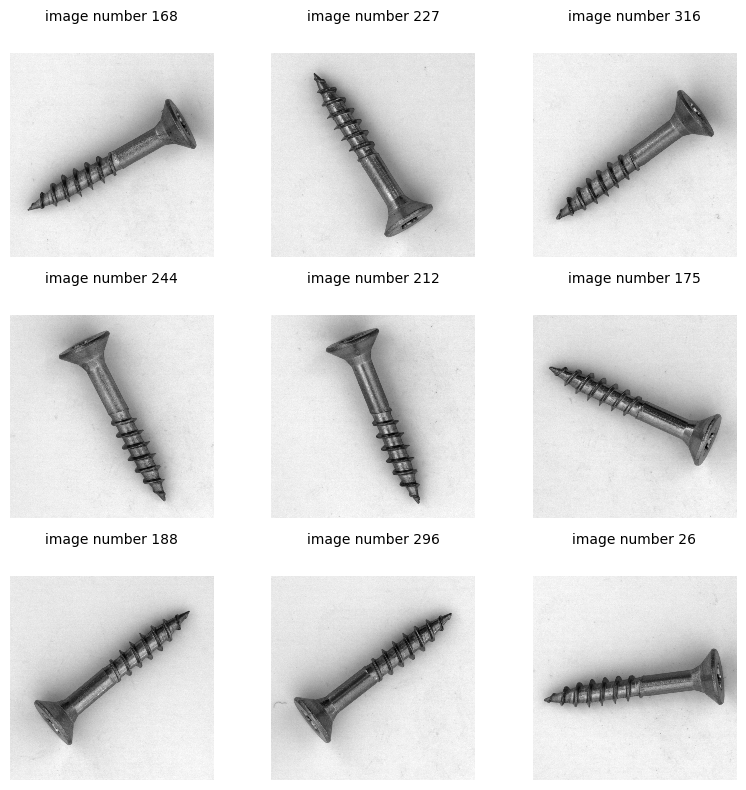

In [175]:
float_formatter = "{:8}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
fig, ax_list = plt.subplots(3, 3, figsize=(8,8))
# extent = (0, 1024, 0, 1024)
do_this = False
for ax in ax_list.flatten():
    img_num = np.random.randint(0, len(train_data))
    img = plt.imread(train_data[img_num])
    ax.matshow(img, cmap='gray', alpha=1, origin='lower')
    ax.set_title(f"image number {img_num}", fontsize=10)
    ax.set_xlim([0, 1024])
    ax.set_ylim([0, 1024])
    ax.axis('off')
fig.tight_layout()
plt.show()

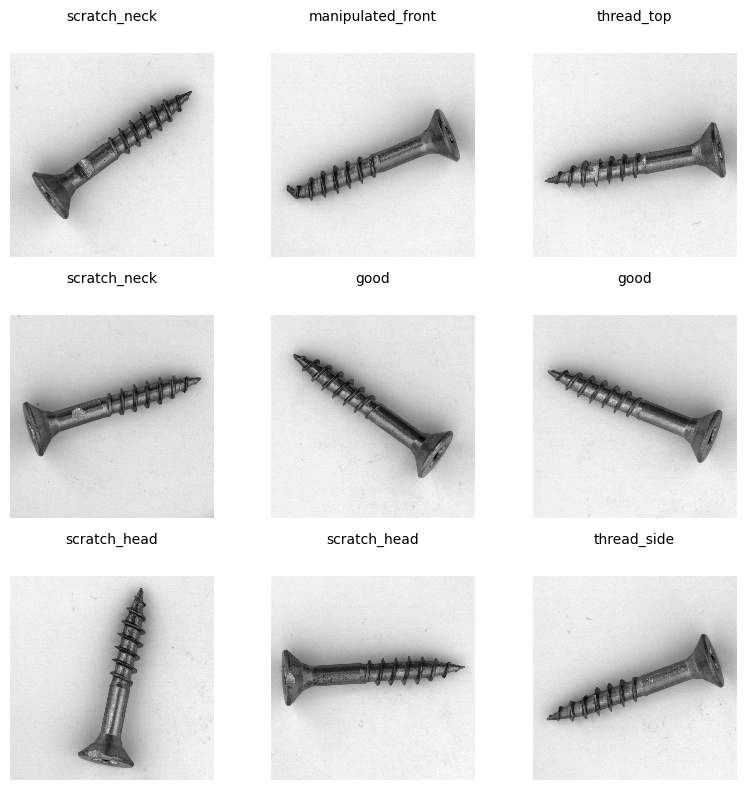

In [176]:
fig_test_samp, ax_test_sample = plt.subplots(3, 3, figsize=(8,8))
for ax in ax_test_sample.flatten():
    test_ind = np.random.randint(0, len(test_data))
    test_img = plt.imread(test_data[test_ind])
    ax.matshow(test_img, cmap='gray', origin='lower')
    ax.axis('off')
    ax.set_title(f"{test_data[test_ind].split('/')[-2]}", fontsize=10)
fig_test_samp.tight_layout()
plt.savefig("./images/eda_anom_grid.png")
plt.show()

## First Model
For the first model I used a very basic autoencoder. It has only a few dense layers to compress
and then reconstruct the images with.

In [177]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim * 4, activation='relu'),
            layers.Dense(latent_dim, activation='relu'),
            ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(latent_dim * 4, activation='relu'),
            layers.Dense(40000, activation='sigmoid'),
            layers.Reshape((200, 200))
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Now that my first model is coded and ready to train I will pull al my test data into a training
and testing `tf.Dataset` objects. This will allow me to work with them as tensors.

In [178]:
train_dir = "./data/screw/train/"
train_dir = pathlib.Path(train_dir)
test_dir = "./data/screw/test/"
test_dir = pathlib.Path(test_dir)

In [179]:
batch_size, img_height, img_width = (320, 200, 200)
x_train = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      seed=142,
                                                      image_size=(img_height, img_width),
                                                      color_mode='grayscale',
                                                      batch_size=None,
                                                      shuffle=False,
                                                      )

Found 320 files belonging to 1 classes.


In [180]:
# test_batch = 160
x_test = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                     seed=142,
                                                     image_size=(img_height, img_width),
                                                     batch_size=None,
                                                     shuffle=False,
                                                     color_mode='grayscale',
                                                    )

Found 160 files belonging to 6 classes.


In [181]:
train_classes = x_train.class_names
train_classes

['good']

## Reshape Datasets

In [182]:
x_train_np = np.array(list(map(lambda x : x[0], x_train.as_numpy_iterator())), 'float16')
x_train_final = x_train_np.astype('float16') / 255
x_train_final = x_train_final.reshape(320, 200, 200)

In [183]:
x_test_np = np.array(list(map(lambda x : x[0], x_test.as_numpy_iterator())), 'float16')
x_test_final = x_test_np.astype('float16') / 255
x_test_final = x_test_final.reshape(160, 200, 200)

In [184]:
with open(f'./data/x_train_{img_height}.pkl', 'wb') as tr_file:
    pickle.dump(x_train_final, tr_file)

In [185]:
with open(f'./data/x_test_{img_height}.pkl', 'wb') as tr_file:
    pickle.dump(x_test_final, tr_file)

In [186]:
latent_dim = 64
autoencoder = Autoencoder(latent_dim)

In [187]:
autoencoder.compile(optimizer='adam', loss=losses.MeanAbsoluteError())

In [188]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/opt/cuda"
autoencoder.fit(x_train_final, x_train_final,
                epochs=50,
                shuffle=True,
                validation_data=(x_test_final, x_test_final))

Epoch 1/50


2022-12-09 16:36:38.376206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 2s 63ms/step - loss: 0.1334 - val_loss: 0.0780
Epoch 2/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0755 - val_loss: 0.0699
Epoch 3/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0699 - val_loss: 0.0703
Epoch 4/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0681 - val_loss: 0.0680
Epoch 5/50
10/10 [==============================] - 0s 27ms/step - loss: 0.0649 - val_loss: 0.0703
Epoch 6/50
10/10 [==============================] - 0s 37ms/step - loss: 0.0623 - val_loss: 0.0618
Epoch 7/50
10/10 [==============================] - 0s 28ms/step - loss: 0.0594 - val_loss: 0.0659
Epoch 8/50
10/10 [==============================] - 0s 25ms/step - loss: 0.0574 - val_loss: 0.0646
Epoch 9/50
10/10 [==============================] - 0s 24ms/step - loss: 0.0542 - val_loss: 0.0542
Epoch 10/50
10/10 [==============================] - 0s 23ms/step - loss: 0.0506 - val_loss: 0.0521
Epoch 11/50
10/10 [=

## The First Results Look Promising

In [189]:
encoded_imgs = autoencoder.encoder(x_test_final).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

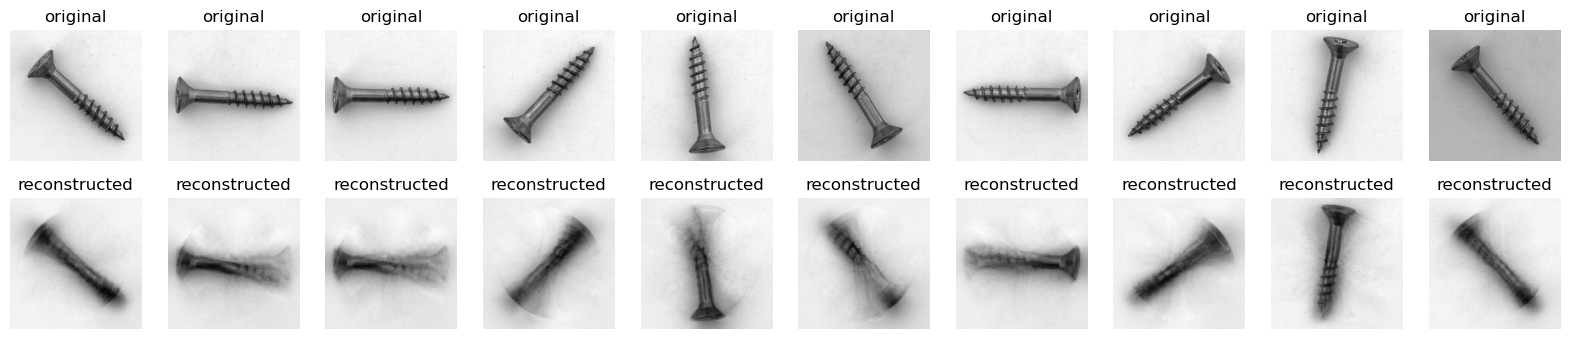

In [191]:
num_of_imgs = 10
plt.figure(figsize=(20,4))
for i in range(num_of_imgs):
    ax = plt.subplot(2, num_of_imgs, i + 1)
    plt.imshow(x_test_final[i], cmap='gray')
    plt.title("original")
    ax.axis('off')

    ax = plt.subplot(2, num_of_imgs, i + 1 + num_of_imgs)
    plt.imshow(decoded_imgs[i], cmap='gray')
    plt.title("reconstructed")
    ax.axis('off')
plt.savefig("./images/first_model_output_vis.png")
plt.show()

## Bellow I am investigating convolutional layers
I wanted to move away from dense layer models and try and 2D Convolutional Neural Network based model but first I wanted to try and understand the process a bit better.

Below I coded and sobol edge finding matrix and passed a test image and the sobol filter through a custom loop that uses two basic convolution layers to process the image.

In [192]:
test_img = x_train_np[3]
test_img = test_img / 255
test_img = test_img.reshape(1, 200, 200, 1)
img_in = tf.constant(test_img, dtype=tf.float32)

In [193]:
kernel_1 = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
kernel_1 = kernel_1.reshape(3, 3, 1, 1)
kernel_1 = tf.constant(kernel_1, dtype=tf.float32)


kernel_2 = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
kernel_2 = kernel_2.reshape(3, 3, 1, 1)
kernel_2 = tf.constant(kernel_2, dtype=tf.float32)

kernel_3 = np.array([[-.5, -.5, 1],
                     [-.5, 1, -.5],
                     [1, -.5, -.5]])
kernel_3 = kernel_3.reshape(3, 3, 1, 1)
kernel_3 = tf.constant(kernel_3, dtype=tf.float32)

kern_list = [kernel_1, kernel_2, kernel_3]

In [194]:
def conv_loop(image, kernels, loops:int=10):
    out_put = []
    for k_in in kernels:
        img_p = image
        img_r = tf.image.rot90(img_p)
        for _ in range(loops):
            conv2d_H = tf.nn.conv2d(image, k_in, strides=(1,1), padding='SAME')
            conv2d_V = tf.nn.conv2d(img_r, k_in, strides=(1,1), padding='SAME')
            conv2d_V  = tf.image.rot90(conv2d_V, k=3)
            img_p = conv2d_H + conv2d_V
        img_fin = img_p.numpy()
        img_fin = img_fin.reshape(200, 200, 1)
        out_put.append(img_fin)
    return out_put

## A Representation of the Edges found by the convolution process

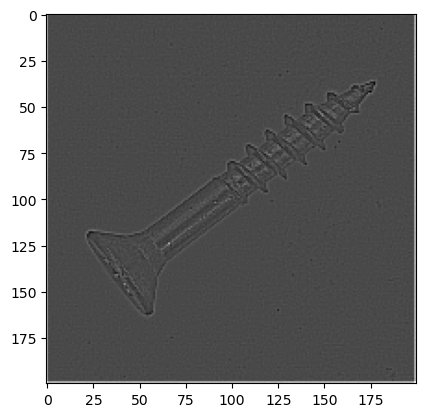

In [195]:
results  = conv_loop(img_in, kern_list, 100)
plt.imshow(results[1], cmap='gray')

# Second Model
Below is the subclassed model that I wrote to handle the autoencoding process. It uses a series of convolutional layers to compress the feature space of the images and hoepfully learn a latent representation that will be strong enough to detect anomalous data.

In [196]:
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = tf.keras.models.Sequential([
            layers.Input(shape=(200, 200, 1)),
            layers.Conv2D(32, (4, 4), activation='relu', padding='same', strides=1),
            layers.MaxPool2D((2,2), padding='same', data_format='channels_last'),
            layers.Conv2D(16, (4, 4), activation='relu', padding='same', strides=1),
            layers.MaxPool2D((2,2), padding='same', data_format='channels_last'),
            layers.Conv2D(8, (4, 4), activation='relu', padding='same', strides=1)
            ])
        self.decoder = Sequential([
            layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, 3, strides=2, activation='sigmoid', padding='same')
            ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [197]:
x_2_train_np = np.array(list(map(lambda x : x[0], x_train.as_numpy_iterator())), 'float16')
x_2_train_final = x_2_train_np.astype('float16') / 255
x_2_train_final = x_2_train_final.reshape(320, 200, 200, 1)
x_2_train_final.shape

(320, 200, 200, 1)

In [198]:
x_2_test_np = np.array(list(map(lambda x : x[0], x_test.as_numpy_iterator())), 'float16')
x_2_test_final = x_2_test_np.astype('float16') / 255
x_2_test_final = x_2_test_final.reshape(160, 200, 200, 1)
x_2_test_final.shape

(160, 200, 200, 1)

In [199]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:
convenc = AutoEncoder()
convenc.compile(optimizer='adam',
                loss=losses.MeanSquaredError())

In [ ]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/drew/conda/envs/tf_env/"
history = convenc.fit(x_2_train_final, x_2_train_final,
            epochs=100,
            shuffle=True,
            callbacks = [callback],
            validation_data=(x_2_test_final, x_2_test_final))

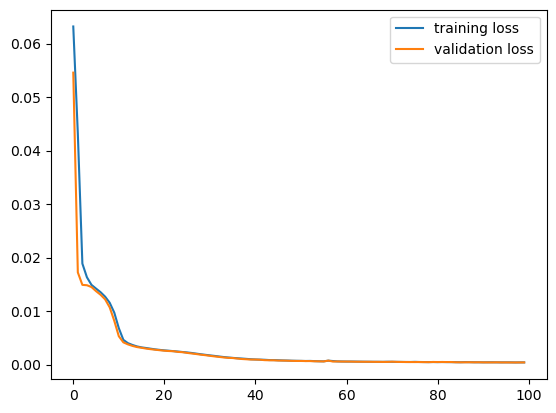

In [164]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# Model 2 Resutls
Below I am using the trained Autoencoder to predict the test data. Then I'm printing out a set of reconstructed screw images just to get a sense of how well the model is trained.

In [201]:
def process_with_model(func, array):
    input_shape = array.shape
    num, width, height, channel = input_shape
    output = None
    for i in range(num):
        batch = func(array[i].reshape(1, width, height, channel)).numpy()
        if output is None:
            output = np.zeros(batch.shape, dtype='float')
        output = np.concatenate((output, batch), axis=0)
    return output[1:]

In [165]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/drew/conda/envs/tf_env/"
encoded_samp = process_with_model(convenc.encoder, x_2_test_final[:16])

In [169]:
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/drew/conda/envs/tf_env/"
out_put = process_with_model(convenc.decoder, encoded_samp)
print(out_put.shape)

(16, 200, 200, 1)


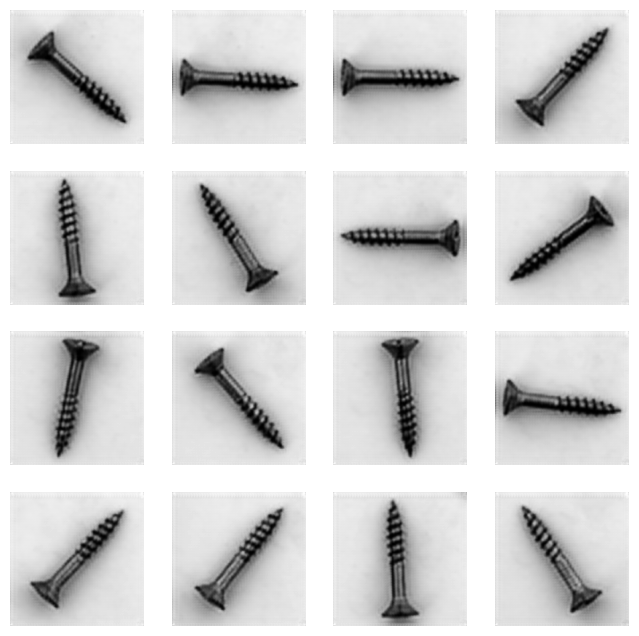

In [171]:
plt.figure(figsize=(8, 8))
for i, img in enumerate(out_put):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.savefig("./images/output_sample.png")
plt.show()

# Putting it to the Test
The reconstructions about look great, but the real test will be to measure the information loss between these reconstructions and the original images. If we're able to determine that the loss distribution is different between the anomalous and normal screws then we will be able to write an algorithm that classifies them.

### Initializing the Normal Test Set

In [202]:
norm_layer = tf.keras.layers.Rescaling(1.0 / 255)

In [209]:
test_good = image_dataset_from_directory(
    "./data/screw/test/good/",
    labels=None,
    seed=142,
    color_mode="grayscale",
    batch_size=None,
    image_size=(200, 200),
)

Found 41 files belonging to 1 classes.


In [210]:
test_good_norm = test_good.map(lambda x: (norm_layer(x)))
print(type(test_good_norm))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [211]:
x_good_np = np.array(
    list(map(lambda x: x, test_good_norm.as_numpy_iterator())), "float32"
)

In [212]:
x_testset = x_good_np

In [213]:
enc_x = process_with_model(convenc.encoder, x_testset)
print(enc_x.shape)

(41, 50, 50, 8)


In [214]:
dec_x = process_with_model(convenc.decoder, enc_x)
print(dec_x.shape)

(41, 200, 200, 1)


### Anomalous Test Data Init
----------------

In [215]:
test_anom = image_dataset_from_directory(
    "./data/screw/test/",
    labels=None,
    shuffle=False,
    color_mode="grayscale",
    batch_size=None,
    image_size=(200, 200),
)

Found 160 files belonging to 1 classes.


In [216]:
test_anom_norm = test_anom.map(lambda x: (norm_layer(x)))

In [217]:
x_anom_np = np.array(
    list(map(lambda x: x, test_anom_norm.as_numpy_iterator())), "float32"
)
# Separate the Anomalous Screws from the Normal Test Set
x_anom_np = x_anom_np[41:]

In [218]:
num, width, height, channel = x_anom_np.shape

In [219]:
enx_c_anom = process_with_model(convenc.encoder, x_anom_np)

In [220]:
dec_x_anom = process_with_model(convenc.decoder, enc_x_anom)

## Calculating the Loss
-----

Test Set Shape: (41, 200, 200, 1)
Reconstructed Set Shape: (41, 200, 200, 1)


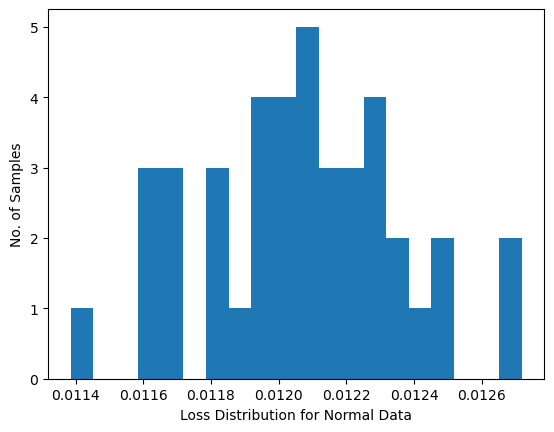

In [221]:
print(f"Test Set Shape: {x_testset.shape}\nReconstructed Set Shape: {dec_x.shape}")
num, width, height, _ = dec_x.shape
y_pred = dec_x.reshape(num, width * height)
y_true = x_testset.reshape(num, width * height)
loss = np.mean(abs(y_true - y_pred), axis=-1)
plt.hist(loss, bins=20)
plt.xlabel("Loss Distribution for Normal Data")
plt.ylabel("No. of Samples")
plt.show()

In [222]:
y_anom_pred = dec_x_anom.reshape(119, 40000)
y_anom_true = x_anom_np.reshape(119, 40000)
loss_anom = np.mean(abs(y_anom_true - y_anom_pred), axis=-1)

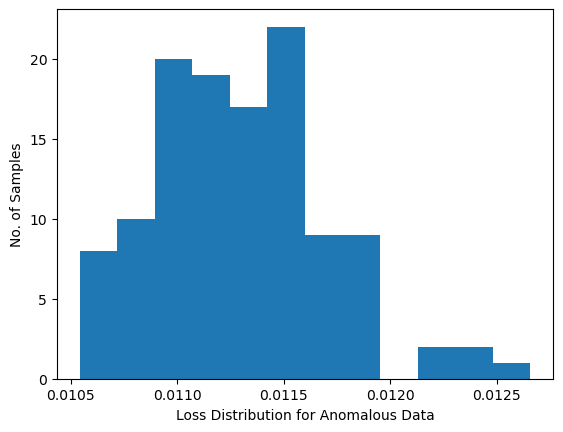

In [223]:
plt.hist(loss_anom, bins=12)
plt.xlabel("Loss Distribution for Anomalous Data")
plt.ylabel("No. of Samples")
plt.show()

In [224]:
loss_hist = np.histogram(loss, bins=20)
loss_max = loss_hist[0].max()
norm_bar_y = loss_hist[0] / loss_max
norm_bar_x = loss_hist[1][1:]

loss_anom_hist = np.histogram(loss_anom, bins=41)
anom_bar_y = loss_anom_hist[0] / loss_anom_hist[0].max()
anom_bar_x = loss_anom_hist[1][1:]

## Setting the Threshold
Below I am setting the threshold value for classifying images as normal or anomalous.

In [228]:
threshold_anom = np.mean(loss) - np.std(loss)
print("Threshold: ", threshold_anom)

Threshold:  0.01177428084537651


In [229]:
norm_y, norm_x = np.histogram(loss, bins=20)
norm_y = norm_y / norm_y.max()

anom_y, anom_x = np.histogram(loss_anom, bins=20)
anom_y = anom_y / anom_y.max()

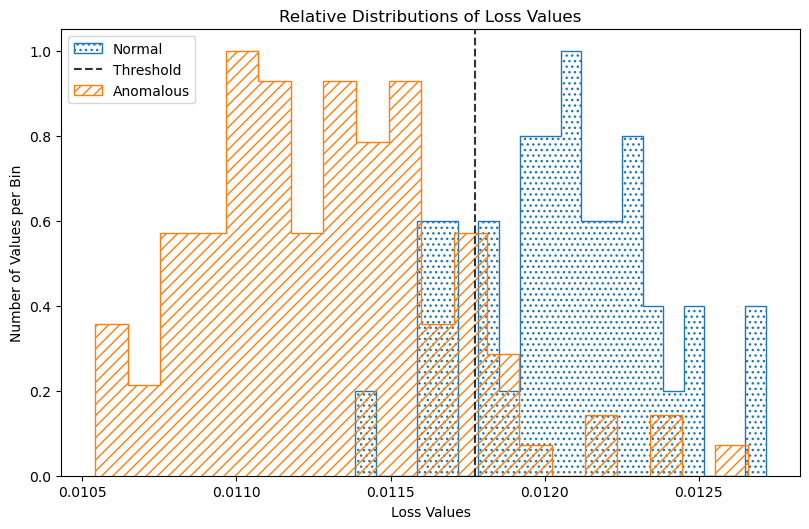

In [230]:
fig, ax = plt.subplots(figsize=(8,5))
ax.stairs(norm_y, norm_x, hatch=('...'), label="Normal")
ax.axvline(x=threshold_anom, c='black', linestyle='--', alpha=.8, label="Threshold")
ax.stairs(anom_y, anom_x, hatch='///', label="Anomalous")
fig.tight_layout()
plt.xlabel("Loss Values")
plt.ylabel("Number of Values per Bin")
plt.title("Relative Distributions of Loss Values")
plt.legend()
plt.savefig("./images/anom_norm_dist.png", dpi=300, bbox_inches='tight', pad_inches=.5)
plt.show()

# Final Output and Accuracy Score
The final look at the models performance shows that there is a lot of room for improvement, however it is working as a proof of concept. Going further I would want to move away from a purely convolutional model because I think it is not abstracting enough away from the images. It seems to be doing a really good job of reconstructing images in general, but it needs to be tuned or some focus mechanism introduced to narrow its output space.

In [238]:
def predict(model, data, threshold):
    encoded = process_with_model(model.encoder, data)
    reconstructions = process_with_model(model.decoder, encoded)
    num, width, height, _ = reconstructions.shape
    reconstructions = reconstructions.reshape(num, width * height)
    model_loss = tf.keras.losses.mae(reconstructions, data.reshape(num, width * height))
    return tf.math.less(threshold, model_loss)

In [239]:
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/drew/conda/envs/tf_env/"
preds = predict(convenc, x_anom_np, threshold_anom)

In [240]:
accuracy = (119 - np.count_nonzero(preds)) / 119
print(f"Accuracy Score: {accuracy*100:.2f}")

Accuracy Score: 88.24
